In [1]:
%pip install python-ffmpeg librosa scikit-learn matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ffmpeg import FFmpeg
import subprocess
import librosa
import json
from scipy.fftpack import fft
from scipy.signal import spectrogram, windows
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [3]:
input_folder="datasets/Data/Audio Recordings/"
input_audio="CAR0001.mp3"
output_audio=f"{input_audio}.wav"

ffmpeg = (
    FFmpeg()
    .option("y")
    .input(f"{input_folder}{input_audio}")
    .output(
        output_audio,
        {"ar:": "16000", "ac": "1", "c:a": "pcm_s16le"},
    )
)
ffmpeg.execute()

b''

In [4]:
out = subprocess.run([
    "/Users/robrohan/Projects/SideProjects/whisper.cpp/build/bin/whisper-cli",
    "--output-lrc",
    "-np",
    "-f",
    f"{output_audio}",
])


[00:00:00.000 --> 00:00:08.360]   brought you in today? Sure, I'm just having a lot of chest pain and so I thought I
[00:00:08.360 --> 00:00:17.920]   should get it checked out. Okay, and before we start, could you remind me of
[00:00:17.920 --> 00:00:28.680]   your gender and age? Sure, 39, I'm a male. Okay, and so when did this chest pain
[00:00:28.680 --> 00:00:40.760]   start? It started last night, but it's becoming sharper. Okay, and where is this
[00:00:40.760 --> 00:00:51.480]   pain located? It's located on the last side of my chest. Okay, and so how long
[00:00:51.480 --> 00:00:57.520]   has it been going on for then if it started last night? So I guess it would
[00:00:57.520 --> 00:01:07.080]   be a couple hours now, maybe like eight. Okay, has it been constant throughout
[00:01:07.080 --> 00:01:17.640]   that time or changing? I would say it's been pretty constant, yeah. Okay, and how
[00:01:17.640 --> 00:01:24.120]   would you describe the pain? People will use words some

output_lrc: saving output to 'CAR0001.mp3.wav.lrc'


[[3762.00316388 3778.21149609 3303.21082521 2220.09077373 2050.64495792
  2146.25870153 1950.00662695 1852.89659589 1950.35537065 2072.30549446
  2116.93436923 2093.18805361 2037.50199714 2096.07007038 2132.57336143
  2140.89461965 2147.10030612 2106.5084289  2076.1368493  2065.61497453
  2057.53052271 2057.46517275 2069.68152856 2062.30288644 2105.28013713
  2129.50913944 2196.28090469 2224.13296542 2217.35420394 2260.74248194
  2352.46743839 2399.22162899 2390.8857997  2381.08890218 2393.33605048
  2449.06367904 2420.39689279 2466.35989875 2518.84869007 2508.99512439
  2493.08347184 2486.00615508 2453.75684669 2422.38168021 2386.69663976
  2411.0070219  2443.38260266 2494.31680841 2508.98304781 2522.44755817
  2543.52114796 2542.79701662 2560.16393949 2543.14872628 2565.48167702
  2602.46091488 2609.78503121 2574.76311956 2642.74660128 2629.14886953
  2649.46869087 2657.39819809 2684.32867121 2716.90795435 2773.14369198
  2784.71050361 2729.96513152 2761.90070248 2777.09736791 2747.3

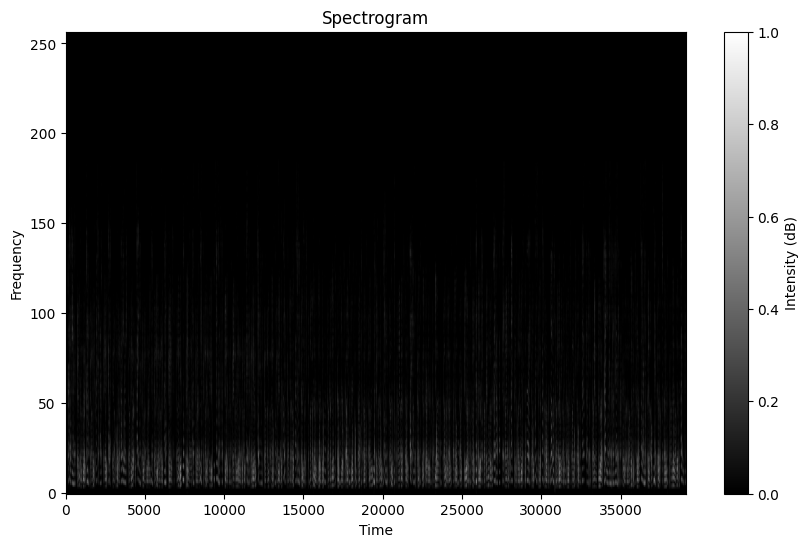

In [ ]:
# Load an audio file
samplerate, data = wavfile.read(output_audio)

# Ensure the data is mono (single channel)
if len(data.shape) > 1:
    data = data[:, 0]

# N = 128         # Number of FFT points
# N = 512         # Number of FFT points
N = 512         # Number of FFT points
noverlap = N >> 1

if N > len(data):
  N = len(data)
  noverlap = N >> 1

# Generate the spectrogram
frequencies, times, Sxx = spectrogram(data, fs=samplerate, window=windows.blackman(N), nfft=N, noverlap=noverlap)

# Convert the spectrogram to decibels (log scale)
Sxx_db = librosa.amplitude_to_db(np.abs(Sxx), ref=np.max)

# Normalize the spectrogram data to the range [0, 1]
Sxx_db_normalized = (Sxx_db - np.min(Sxx_db)) / (np.max(Sxx_db) - np.min(Sxx_db))

# Spectral Centroid
centroid = librosa.feature.spectral_centroid(y=Sxx_db_normalized, sr=samplerate)
print(np.mean(centroid.T, axis=0))

# Save the spectrogram as an image
plt.imsave('spectrogram.png', Sxx_db_normalized, cmap='gray', vmin=0, vmax=1)

# Save metadata
# metadata = {
#     'samplerate': samplerate,
#     'nperseg': N,
#     'noverlap': noverlap,
#     'shape': Sxx_db_normalized.shape,
#     'min_db': float(np.min(Sxx_db)),
#     'max_db': float(np.max(Sxx_db))
# }
# with open('metadata.json', 'w') as f:
#     json.dump(metadata, f)

# Optionally, display the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(Sxx_db_normalized, aspect='auto', cmap='gray', origin='lower', vmin=0, vmax=1)
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Intensity (dB)')
plt.show()